In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from datetime import datetime
from scipy import stats

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from mlxtend.feature_selection import ColumnSelector
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

### 优惠券特征的提取

+ 历史出现次数
+ 历史核销次数
+ 历史核销率
+ 历史核销时间率
+ 历史上用户领取该优惠券次数
+ 历史上用户消费该优惠券次数
+ 历史上用户对该优惠券的核销率

In [15]:
base_features_df = pd.read_csv('../features/lcm_base_features.csv')

In [16]:
base_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 16 columns):
User_id              int64
Merchant_id          float64
Coupon_id            float64
Distance             float64
Date_received        float64
Is_in_day_consume    float64
Discount             float64
Base_consume         float64
Discount_money       float64
Day_in_month         float64
Day_in_week          float64
Month_in_year        float64
Coupon_type          float64
Offline_consume      float64
Duration             float64
Is_used_coupon       float64
dtypes: float64(15), int64(1)
memory usage: 214.2 MB


In [27]:
def is_debug_df(df, date=20160501, debug=True):
    if debug:
        return df[df['Date_received']<date]
    else:
        return df.copy()
    
df = is_debug_df(base_features_df, debug=True)
df = df[df['Coupon_id'] > 0]

In [18]:
def join(df, col, series, key):
    return multi_join(df, col, series, [key])

def multi_join(df, col, series, keys):
    t = series.to_frame()
    t.columns = [col]
    
    return pd.merge(df, t, on=keys, how='left')

In [19]:
def receive_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Date_received']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Date_received']>0][target].groupby(groupby).size()

def cousume_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Offline_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Offline_consume']>0][target].groupby(groupby).size()

def used_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Is_in_day_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Is_in_day_consume']>0][target].groupby(groupby).size()

def cal_user_used_coupon_rate(row):
    return row.User_used_count/row.User_receive_count

def cal_user_not_used_conpon_count(row):
    return row.User_receive_count - row.User_used_count

def extract_info(df, target, type, groupby, column_name, is_dup=True):
    factory = {
        'receive_type': receive_count,
        'used_type': used_count
    }
    
    target_df = df[groupby].drop_duplicates()
    series = factory[type](df, target, groupby, is_dup)
    
    tdf = multi_join(target_df, column_name, series, groupby)
    tdf = tdf.fillna(0)
    
#     mean = tdf[column_name].mean()
#     tdf[column_name+'_occ'] = tdf[column_name] / mean
    return tdf[groupby + [column_name,]]

In [20]:
class GroupbyExtractor(TransformerMixin):
    def __init__(self, fn, target, type, groupby, column_name):
        self.fn = fn
        self.target = target
        self.type = type
        self.groupby = groupby
        self.column_name = column_name
    
    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, **transform_params):
        return self.fn(X, self.target, self.type, self.groupby, self.column_name)

In [21]:
keys = ['Coupon_id']
coupon_features_df = df[['Coupon_id']].drop_duplicates()

coupon_features_df = pd.merge(coupon_features_df, extract_info(df, ['Coupon_id'], 'receive_type', keys, 'Coupon_receive_count', False), on=keys, how='left')
coupon_features_df = pd.merge(coupon_features_df, extract_info(df, ['Coupon_id'], 'used_type', keys, 'Coupon_used_count', False), on=keys, how='left')
coupon_features_df = pd.merge(coupon_features_df, extract_info(df, ['Coupon_id', 'User_id'], 'receive_type', keys, 'Coupon_diff_user_receive_count'), on=keys, how='left')
coupon_features_df = pd.merge(coupon_features_df, extract_info(df, ['Coupon_id', 'User_id'], 'used_type', keys, 'Coupon_diff_user_used_count'), on=keys, how='left')

for i in range(0, 12, 1):
    
    coupon_features_df = pd.merge(
        coupon_features_df, 
        extract_info(
            df[df['Distance'] == i], 
            ['Coupon_id', 'Distance'], 
            'receive_type', 
            keys, 
            'Coupon_receive_distance_%s_count' % (i),
            False
        ), 
        on=keys, how='left'
    )
    
    coupon_features_df = pd.merge(
        coupon_features_df, 
        extract_info(
            df[df['Distance'] == i], 
            ['Coupon_id', 'Distance'], 
            'used_type', 
            keys, 
            'Coupon_used_distance_%s_count' % (i),
            False
        ), on=keys, how='left')
    
    coupon_features_df['Coupon_used_distance_%s_rate' % (i)] = coupon_features_df['Coupon_used_distance_%s_count' % (i)] / coupon_features_df['Coupon_used_count']

coupon_features_df['Coupon_used_rate'] = coupon_features_df['Coupon_used_count'] / coupon_features_df['Coupon_receive_count']

user_count = df['User_id'].unique().size
coupon_features_df['Coupon_diff_user_receive_rate'] = coupon_features_df['Coupon_diff_user_receive_count'] / user_count
coupon_features_df['Coupon_diff_user_used_rate'] = coupon_features_df['Coupon_diff_user_used_count'] / user_count

coupon_features_df = coupon_features_df.fillna(0)

# coupon_features_df['Coupon_used_rate_occ'] = coupon_features_df['Coupon_used_rate'] / coupon_features_df['Coupon_used_rate'].mean()

In [22]:
t = base_features_df[['Coupon_id', 'Distance']].groupby('Coupon_id').agg(['mean', 'max', 'min'])
t.columns = ["_Coupon_".join(x) for x in t.columns.ravel()]
coupon_features_df = pd.merge(coupon_features_df, t, on=keys, how='left')

In [23]:
coupon_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9738 entries, 0 to 9737
Data columns (total 47 columns):
Coupon_id                           9738 non-null float64
Coupon_receive_count                9738 non-null int64
Coupon_used_count                   9738 non-null float64
Coupon_diff_user_receive_count      9738 non-null int64
Coupon_diff_user_used_count         9738 non-null float64
Coupon_receive_distance_0_count     9738 non-null float64
Coupon_used_distance_0_count        9738 non-null float64
Coupon_used_distance_0_rate         9738 non-null float64
Coupon_receive_distance_1_count     9738 non-null float64
Coupon_used_distance_1_count        9738 non-null float64
Coupon_used_distance_1_rate         9738 non-null float64
Coupon_receive_distance_2_count     9738 non-null float64
Coupon_used_distance_2_count        9738 non-null float64
Coupon_used_distance_2_rate         9738 non-null float64
Coupon_receive_distance_3_count     9738 non-null float64
Coupon_used_distance_3_coun

In [24]:
coupon_features_df.columns.values

array(['Coupon_id', 'Coupon_receive_count', 'Coupon_used_count',
       'Coupon_diff_user_receive_count', 'Coupon_diff_user_used_count',
       'Coupon_receive_distance_0_count', 'Coupon_used_distance_0_count',
       'Coupon_used_distance_0_rate', 'Coupon_receive_distance_1_count',
       'Coupon_used_distance_1_count', 'Coupon_used_distance_1_rate',
       'Coupon_receive_distance_2_count', 'Coupon_used_distance_2_count',
       'Coupon_used_distance_2_rate', 'Coupon_receive_distance_3_count',
       'Coupon_used_distance_3_count', 'Coupon_used_distance_3_rate',
       'Coupon_receive_distance_4_count', 'Coupon_used_distance_4_count',
       'Coupon_used_distance_4_rate', 'Coupon_receive_distance_5_count',
       'Coupon_used_distance_5_count', 'Coupon_used_distance_5_rate',
       'Coupon_receive_distance_6_count', 'Coupon_used_distance_6_count',
       'Coupon_used_distance_6_rate', 'Coupon_receive_distance_7_count',
       'Coupon_used_distance_7_count', 'Coupon_used_distance_7_ra

In [25]:
coupon_features_df.to_csv('../features/lcm_coupon_features.csv', index=False, header=True)

## 数据分析

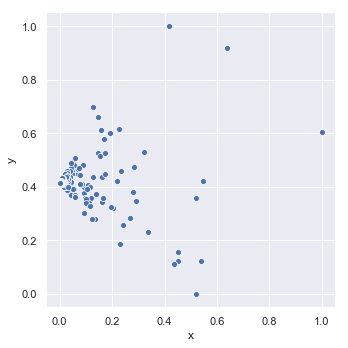

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

tdf = pd.read_csv('../features/lcm_coupon_features.csv')
tdf = tdf.drop(['Coupon_id'], axis=1)

ipipe = Pipeline([
    ('pca', PCA(n_components=2)),
    ('scale', MinMaxScaler()),
])

ipipe.fit(tdf)
output = ipipe.transform(tdf)
output_df = pd.DataFrame(data=output, columns=['x', 'y'])

sns.relplot(x="x", y="y", data=output_df);